In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Conclusions (except GAMs)

Logistic (3000 iters, C=0.5): f1-score \[0.63104 0.61646 0.46957 0.45263\] average **0.54243**

LinearSVC (3000 iters): f1-score \[0.44227 0.56054 0.37681 0.00000\] average 0.34490

Linear Regressor: f1-score \[0.55314 0.60685 0.45087 0.36686\] average 0.49443

LinearSVR (C=0.5, loss='squared_epsilon_insensitive'): f1-score \[0.55410 0.56790 0.41935 0.32836\] average 0.46743

KNN Regressor: f1-score \[0.56949 0.59104 0.40796 0.40462\] average 0.49328

SVR + PolynomialCountSketch (degree=3, n_components=300): f1-score \[0.53251 0.52676 0.35599 0.34419\] average 0.43986 

SVR + Nystroem (kernel='poly', degree=3): f1-score \[0.59880 0.59788 0.35808 0.28571\] average 0.46012

SplineTransformer + SVR + Nystroem (kernel='poly', degree=3): f1-score \[0.62958 0.61941 0.44131 0.38235\] average 0.51817

MARS (degree=3, max_terms=500): f1-score \[0.58047 0.62646 0.44809 0.45902\] average 0.52851

MARS (degree=4, max_terms=500): f1-score \[0.58047 0.62829 0.44809 0.45902\] average 0.52897 (no difference at all!)

In [2]:
# read Dataset as Pandas DataFrame
print("================ Reading dataset ===============")
dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_24.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

================ Reading dataset ===============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44837 entries, 0 to 44836
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LOW_IMPACT     44837 non-null  bool   
 1   MID_IMPACT     44837 non-null  bool   
 2   BIG_IMPACT     44837 non-null  bool   
 3   DIRECT_STRIKE  44837 non-null  bool   
 4   MM00           44837 non-null  int32  
 5   DD00           44837 non-null  int32  
 6   HH00           44837 non-null  int32  
 7   MI_STATUS00    44837 non-null  bool   
 8   LI_STATUS00    44837 non-null  bool   
 9   SI_STATUS00    44837 non-null  bool   
 10  DS_STATUS00    44837 non-null  bool   
 11  DIST00         44837 non-null  float64
 12  AZM00          44837 non-null  float64
 13  SPEED00        44837 non-null  int32  
 14  DIR00          44837 non-null  int32  
 15  VMAX00         44837 non-null  int32  
 16  DVMAX00        44837 non-null  int32  
 17  M

In [3]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

# Constants
TRAIN_RATIO = 0.9

In [4]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,0:4]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36317; Dev set size: 4036; Testing set size: 4484


### Tools

In [5]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [6]:
# new utility functions
from scipy.special import expit

def regression_predict(regr, datasetX, method='sigmoid'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='sigmoid'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='sigmoid'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

### Solid proof that PCA and Poly features don't always work

In [7]:
# imports
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem, PolynomialCountSketch
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

In [8]:
poly = PolynomialFeatures(degree=3, include_bias=False)
transformed_X = poly.fit_transform(train_X)

transformed_X.shape

(36317, 47904)

In [9]:
std_X = StandardScaler().fit(transformed_X)
standard_X = std_X.transform(transformed_X)
pca = PCA(n_components=450)
pca.fit(standard_X)

MemoryError: Unable to allocate 13.0 GiB for an array with shape (36317, 47904) and data type float64

### Classifiers

In [19]:
basic_clf_1 = OneVsRestClassifier(LogisticRegression(
    max_iter=3000,
    C=0.5,
    verbose=0   
), n_jobs=-1)

basic_clf_1 = basic_clf_1.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_1.predict(train_X))))

# test model on dev set
preds = basic_clf_1.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0))

Training accuracy: 0.9056089435
Accuracy of classifier on dev set: 0.9023785927
              precision    recall  f1-score   support

           0       0.78      0.39      0.52       382
           1       0.77      0.43      0.56       299
           2       0.70      0.30      0.42       105
           3       0.81      0.20      0.32        86

   micro avg       0.77      0.38      0.50       872
   macro avg       0.77      0.33      0.45       872
weighted avg       0.77      0.38      0.50       872
 samples avg       0.06      0.05      0.05       872



Best Threshold=0.25931, F-Score=0.63278
Best Threshold=0.31932, F-Score=0.61888
Best Threshold=0.22358, F-Score=0.47619
Best Threshold=0.16160, F-Score=0.46073


/tmp/.u3556490/ipykernel_19844/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_19844/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_19844/2472075379.py:11: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


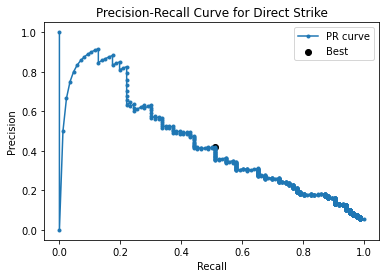

In [20]:
best_thresholds, best_f1_scores = optimize_thresholds(basic_clf_1, dev_X, dev_Y)

In [21]:
preds = predictions_with_thresholds(basic_clf_1, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.61386   0.64921   0.63104       382
           1    0.64706   0.58863   0.61646       299
           2    0.43200   0.51429   0.46957       105
           3    0.41346   0.50000   0.45263        86

   micro avg    0.57569   0.59748   0.58638       872
   macro avg    0.52660   0.56303   0.54243       872
weighted avg    0.58358   0.59748   0.58900       872
 samples avg    0.07099   0.07514   0.06810       872



In [24]:
from sklearn.svm import LinearSVC

basic_clf_2 = OneVsRestClassifier(LinearSVC(dual=False, max_iter=3000), n_jobs=-1)

basic_clf_2 = basic_clf_2.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_2.predict(train_X))))

# test model on dev set
preds = basic_clf_2.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

Training accuracy: 0.9098769171
Accuracy of classifier on dev set: 0.9043607532
              precision    recall  f1-score   support

           0    0.87597   0.29581   0.44227       382
           1    0.85034   0.41806   0.56054       299
           2    0.78788   0.24762   0.37681       105
           3    0.00000   0.00000   0.00000        86

   micro avg    0.85161   0.30275   0.44670       872
   macro avg    0.62855   0.24037   0.34490       872
weighted avg    0.77018   0.30275   0.43132       872
 samples avg    0.05024   0.04326   0.04484       872



### Regressors

In [25]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

linear_regr = MultiOutputRegressor(LinearRegression(), n_jobs=-1)
linear_regr = linear_regr.fit(train_X, train_Y)

Best Threshold=0.54235, F-Score=0.55489
Best Threshold=0.53258, F-Score=0.60912
Best Threshold=0.56001, F-Score=0.45977
Best Threshold=0.53058, F-Score=0.37647


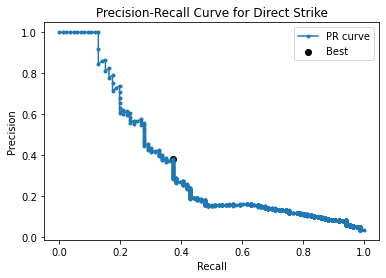

In [26]:
best_thresholds, best_f1_scores = regressor_find_thresholds(linear_regr, dev_X, dev_Y, 'sigmoid')

In [27]:
preds = regression_label(linear_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.51345   0.59948   0.55314       382
           1    0.59236   0.62207   0.60685       299
           2    0.57353   0.37143   0.45087       105
           3    0.37349   0.36047   0.36686        86

   micro avg    0.53238   0.55619   0.54403       872
   macro avg    0.51321   0.48836   0.49443       872
weighted avg    0.53394   0.55619   0.54087       872
 samples avg    0.06093   0.07220   0.06141       872



In [28]:
from sklearn.svm import LinearSVR

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

svr_regr = svr_regr.fit(train_X, train_Y)

Best Threshold=0.54423, F-Score=0.55582
Best Threshold=0.53631, F-Score=0.57011
Best Threshold=0.55921, F-Score=0.42781
Best Threshold=0.53509, F-Score=0.34074


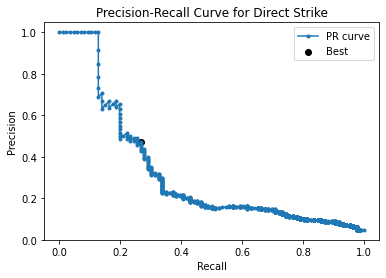

In [29]:
best_thresholds, best_f1_scores = regressor_find_thresholds(svr_regr, dev_X, dev_Y, 'sigmoid')

In [30]:
preds = regression_label(svr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.50763   0.60995   0.55410       382
           1    0.52722   0.61538   0.56790       299
           2    0.48148   0.37143   0.41935       105
           3    0.45833   0.25581   0.32836        86

   micro avg    0.51014   0.54817   0.52847       872
   macro avg    0.49367   0.46314   0.46743       872
weighted avg    0.50633   0.54817   0.52034       872
 samples avg    0.06357   0.07189   0.06280       872



In [46]:
from sklearn.neighbors import KNeighborsRegressor

knr_regr = MultiOutputRegressor(KNeighborsRegressor(weights='distance'), n_jobs=-1)

knr_regr = knr_regr.fit(train_X, train_Y)

Best Threshold=0.58824, F-Score=0.57111
Best Threshold=0.56580, F-Score=0.59301
Best Threshold=0.60054, F-Score=0.41584
Best Threshold=0.56174, F-Score=0.41379


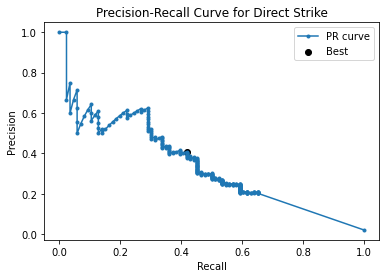

In [47]:
best_thresholds, best_f1_scores = regressor_find_thresholds(knr_regr, dev_X, dev_Y, 'sigmoid')

In [48]:
preds = regression_label(knr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.50099   0.65969   0.56949       382
           1    0.50843   0.70569   0.59104       299
           2    0.42708   0.39048   0.40796       105
           3    0.40230   0.40698   0.40462        86

   micro avg    0.48955   0.61812   0.54638       872
   macro avg    0.45970   0.54071   0.49328       872
weighted avg    0.48491   0.61812   0.54117       872
 samples avg    0.07130   0.07677   0.06956       872



In [66]:
from sklearn.preprocessing import SplineTransformer

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

pipe = make_pipeline(
    SplineTransformer(include_bias=False),
    StandardScaler(),
    # PolynomialCountSketch(degree=3, n_components=300),
    Nystroem(kernel='poly', degree=3),
    svr_regr, verbose=True
)
print(pipe)

poly_svr_regr = pipe.fit(train_X, train_Y)

Pipeline(steps=[('splinetransformer', SplineTransformer(include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('nystroem', Nystroem(degree=3, kernel='poly')),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.5, dual=False,
                                                          loss='squared_epsilon_insensitive'),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] . (step 1 of 4) Processing splinetransformer, total=   1.2s
[Pipeline] .... (step 2 of 4) Processing standardscaler, total=   0.2s
[Pipeline] .......... (step 3 of 4) Processing nystroem, total=   0.4s
[Pipeline]  (step 4 of 4) Processing multioutputregressor, total=   4.0s


Best Threshold=0.56109, F-Score=0.63131
Best Threshold=0.55320, F-Score=0.62154
Best Threshold=0.55588, F-Score=0.44860
Best Threshold=0.53810, F-Score=0.39416


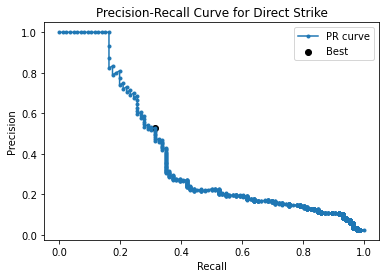

In [67]:
best_thresholds, best_f1_scores = regressor_find_thresholds(poly_svr_regr, dev_X, dev_Y, 'sigmoid')

In [68]:
preds = regression_label(poly_svr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.60880   0.65183   0.62958       382
           1    0.57429   0.67224   0.61941       299
           2    0.43519   0.44762   0.44131       105
           3    0.52000   0.30233   0.38235        86

   micro avg    0.57034   0.59977   0.58468       872
   macro avg    0.53457   0.51850   0.51817       872
weighted avg    0.56730   0.59977   0.57904       872
 samples avg    0.06977   0.07693   0.06839       872



### Ultimate weapon: Regression splines
#### MARS

In [55]:
from pyearth import Earth
earth_regr = MultiOutputRegressor(Earth(max_degree=4, max_terms=500, use_fast=True), n_jobs=-1)
earth_regr = earth_regr.fit(train_X, train_Y)

Best Threshold=0.55903, F-Score=0.58235
Best Threshold=0.55069, F-Score=0.63054
Best Threshold=0.55598, F-Score=0.45652
Best Threshold=0.53782, F-Score=0.46739


/tmp/.u3556490/ipykernel_19844/984687278.py:20: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


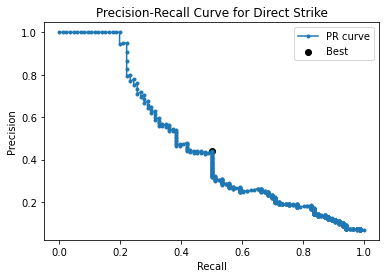

In [56]:
best_thresholds, best_f1_scores = regressor_find_thresholds(earth_regr, dev_X, dev_Y, 'sigmoid')

In [57]:
preds = regression_label(earth_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.58511   0.57592   0.58047       382
           1    0.61812   0.63880   0.62829       299
           2    0.52564   0.39048   0.44809       105
           3    0.43299   0.48837   0.45902        86

   micro avg    0.57442   0.56651   0.57044       872
   macro avg    0.54047   0.52339   0.52897       872
weighted avg    0.57426   0.56651   0.56895       872
 samples avg    0.06956   0.07313   0.06717       872



### Ultimate Weapon Mk. II Ausf. B *Electric Boogaloo*: GAM 
Taking into account how the simple baseline dataset's GAMs collapse (OOM) when there are more than (approx) a few thousand splines to fit,
one must be cautious in choosing what to do with this here. It must also be noted that the models behave in a highly consistent and deterministic way, such that if the parameters are fixed then the performance scores are going to be identical.

default settings for all, all features, linear GAM: f1-score \[0.67984 0.65203 0.57895 0.46154\] average 0.59309  
100 splines each, omit hour and day, all features, linear GAM: f1-score \[0.66265 0.65291 0.55249 0.47826\] average 0.58658   
factor terms for all, omit hour and day, linearGAM: OOM   
200 splines each, omit hour and day, linearGAM: didn't OOM (yay), f1-score \[0.65284 0.65107 0.53086 0.45128\] average 0.57151   
400 splines each, omit hour and day, linearGAM: likely OOM, no tests made   

With prior feature selection from a tree: f1-score for the first target struggled to pass 0.6  
With prior feature selection by copying from HKWW: same results  
Notable feature combos: 
- te(7,8,9)+te(3,7,8)+te(7,10,9) => 0.62396  
- te(7,8,9)+te(3,7,8)+te(7,10,9)+
  te(20,21,22)+te(16,20,21)+te(20,23,22)+
  s(3)+s(7)+s(8)+s(12)+s(20) => 0.64358  
(These are for target 0)

##### Target by target, all original features

In [8]:
from pygam import LinearGAM, s, l, f, te

gams = []
for i in range(4):
    gam = LinearGAM(
        s(0, n_splines=200)+s(3, n_splines=200)+s(4, n_splines=200)+s(5, n_splines=200)+
        s(6, n_splines=200)+s(7, n_splines=200)+s(8, n_splines=200)+s(9, n_splines=200)+
        s(10, n_splines=200)+s(11, n_splines=200)+s(12, n_splines=200)+s(13, n_splines=200)+
        s(16, n_splines=200)+s(17, n_splines=200)+s(18, n_splines=200)+s(19, n_splines=200)+
        s(20, n_splines=200)+s(21, n_splines=200)+s(22, n_splines=200)+s(23, n_splines=200)+
        s(24, n_splines=200)+s(25, n_splines=200)+s(26, n_splines=200)+s(29, n_splines=200)+
        s(30, n_splines=200)+s(31, n_splines=200)+s(32, n_splines=200)+s(33, n_splines=200)+
        s(34, n_splines=200)+s(35, n_splines=200)+s(36, n_splines=200)+s(37, n_splines=200)+
        s(38, n_splines=200)+s(39, n_splines=200)+s(42, n_splines=200)+s(43, n_splines=200)+
        s(44, n_splines=200)+s(45, n_splines=200)+s(46, n_splines=200)+s(47, n_splines=200)+
        s(48, n_splines=200)+s(49, n_splines=200)+s(50, n_splines=200)+s(51, n_splines=200)+
        s(52, n_splines=200)+s(55, n_splines=200)+s(56, n_splines=200)+s(57, n_splines=200)+
        s(58, n_splines=200)+s(59, n_splines=200)+s(60, n_splines=200)+s(61, n_splines=200)+
        s(62, n_splines=200)+s(63, n_splines=200),
        max_iter=1000, verbose=True
    ).fit(train_X, train_Y[:,i])
    print(gam.summary())
    gams.append(gam)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2694.7756
Link Function:                     IdentityLink Log Likelihood:                                -314005.624
Number of Samples:                        36317 AIC:                                           633402.7991
                                                AICc:                                           633835.271
                                                GCV:                                                 0.049
                                                Scale:                                              0.0425
                                                Pseudo R-Squared:                                   0.5211
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6465/3545004482.py:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2694.7756
Link Function:                     IdentityLink Log Likelihood:                                -424140.632
Number of Samples:                        36317 AIC:                                           853672.8151
                                                AICc:                                          854105.2871
                                                GCV:                                                0.0376
                                                Scale:                                              0.0326
                                                Pseudo R-Squared:                                   0.5327
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6465/3545004482.py:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2694.7756
Link Function:                     IdentityLink Log Likelihood:                                -909282.493
Number of Samples:                        36317 AIC:                                          1823956.5371
                                                AICc:                                          1824389.009
                                                GCV:                                                0.0189
                                                Scale:                                              0.0164
                                                Pseudo R-Squared:                                   0.4119
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6465/3545004482.py:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2694.7756
Link Function:                     IdentityLink Log Likelihood:                              -1142125.9672
Number of Samples:                        36317 AIC:                                          2289643.4856
                                                AICc:                                         2290075.9576
                                                GCV:                                                0.0153
                                                Scale:                                              0.0133
                                                Pseudo R-Squared:                                   0.3179
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6465/3545004482.py:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [9]:
raw_preds = [model.predict(dev_X) for model in gams]
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

(4036, 4)


Best Threshold=0.32632, F-Score=0.65470
Best Threshold=0.36150, F-Score=0.65370
Best Threshold=0.39397, F-Score=0.53988
Best Threshold=0.17680, F-Score=0.45918


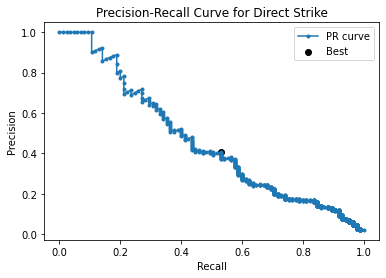

In [10]:
best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

In [11]:
preds = []
# iterate each predicted probability and compare against threshold
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

In [12]:
print(classification_report(dev_Y, preds, digits=5, zero_division=0))

              precision    recall  f1-score   support

           0    0.66479   0.64130   0.65284       368
           1    0.73568   0.58392   0.65107       286
           2    0.87755   0.38053   0.53086       113
           3    0.40000   0.51765   0.45128        85

   micro avg    0.66127   0.57512   0.61519       852
   macro avg    0.66951   0.53085   0.57151       852
weighted avg    0.69039   0.57512   0.61596       852
 samples avg    0.07311   0.07002   0.06775       852



In [14]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36317 entries, 33792 to 25486
Data columns (total 64 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MM00         36317 non-null  int32  
 1   DD00         36317 non-null  int32  
 2   HH00         36317 non-null  int32  
 3   MI_STATUS00  36317 non-null  bool   
 4   LI_STATUS00  36317 non-null  bool   
 5   SI_STATUS00  36317 non-null  bool   
 6   DS_STATUS00  36317 non-null  bool   
 7   DIST00       36317 non-null  float64
 8   AZM00        36317 non-null  float64
 9   SPEED00      36317 non-null  int32  
 10  DIR00        36317 non-null  int32  
 11  VMAX00       36317 non-null  int32  
 12  DVMAX00      36317 non-null  int32  
 13  MM06         36317 non-null  int32  
 14  DD06         36317 non-null  int32  
 15  HH06         36317 non-null  int32  
 16  MI_STATUS06  36317 non-null  bool   
 17  LI_STATUS06  36317 non-null  bool   
 18  SI_STATUS06  36317 non-null  bool   
 19  

In [32]:
for i in range(5):
    print("te({0},{1},{2})+".format(7+13*i,8+13*i,9+13*i),end='') # position and intensity
    print("te({0},{1},{2})+".format(3+13*i,7+13*i,8+13*i),end='') # position and signal 1
    print("te({0},{1},{2})+".format(7+13*i,10+13*i,9+13*i),end='') # direction and distance and speed
    print()

for i in range(4):
    print("te({0},{1},{2})+".format(3+i, 16+i, 29+i)) # signal change trend

te(7,8,9)+te(3,7,8)+te(7,10,9)+
te(20,21,22)+te(16,20,21)+te(20,23,22)+
te(33,34,35)+te(29,33,34)+te(33,36,35)+
te(46,47,48)+te(42,46,47)+te(46,49,48)+
te(59,60,61)+te(55,59,60)+te(59,62,61)+
te(3,16,29)+
te(4,17,30)+
te(5,18,31)+
te(6,19,32)+



In [26]:
for i in range(64):
    if "DD" in train_X.columns[i] or "HH" in train_X.columns[i]: continue
    print("s({0}, n_splines=200)+".format(i), end='')
print()

s(0, n_splines=200)+s(3, n_splines=200)+s(4, n_splines=200)+s(5, n_splines=200)+s(6, n_splines=200)+s(7, n_splines=200)+s(8, n_splines=200)+s(9, n_splines=200)+s(10, n_splines=200)+s(11, n_splines=200)+s(12, n_splines=200)+s(13, n_splines=200)+s(16, n_splines=200)+s(17, n_splines=200)+s(18, n_splines=200)+s(19, n_splines=200)+s(20, n_splines=200)+s(21, n_splines=200)+s(22, n_splines=200)+s(23, n_splines=200)+s(24, n_splines=200)+s(25, n_splines=200)+s(26, n_splines=200)+s(29, n_splines=200)+s(30, n_splines=200)+s(31, n_splines=200)+s(32, n_splines=200)+s(33, n_splines=200)+s(34, n_splines=200)+s(35, n_splines=200)+s(36, n_splines=200)+s(37, n_splines=200)+s(38, n_splines=200)+s(39, n_splines=200)+s(42, n_splines=200)+s(43, n_splines=200)+s(44, n_splines=200)+s(45, n_splines=200)+s(46, n_splines=200)+s(47, n_splines=200)+s(48, n_splines=200)+s(49, n_splines=200)+s(50, n_splines=200)+s(51, n_splines=200)+s(52, n_splines=200)+s(55, n_splines=200)+s(56, n_splines=200)+s(57, n_splines=200)+

##### Generating features from trees

K=100, lam=0.6, n_splines=20: f1-score \[0.47251 0.57642 0.40217 0.26882\] average 0.42998  
K=200, lam=0.6, n_splines=20: f1-score \[**0.69942** 0.61233 0.49398 0.41593\] average 0.55542  
K=300, lam=0.6, n_splines=20: f1-score \[0.69578 0.63621 0.55056 0.42254\] average 0.57627  

Compare original: \[0.67984 **0.65203** **0.57895** **0.46154**\] average 0.59309

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from pygam import LinearGAM, s
from scipy.special import expit

# modify data
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
transformed_X = poly.fit_transform(train_X)

all_sfms = []
all_gams = []
K = 300
lam = 0.6
n_splines=20

terms = s(0, lam=lam, n_splines=n_splines)
for i in range(1,K):
    terms += s(i, lam=lam, n_splines=n_splines)

for i in range(4):
    # build tree to select
    clf = ExtraTreesClassifier(random_state=42).fit(transformed_X, train_Y[:,i])
    print("Target {0} of 4: Tree fitted, score {1}".format(i, clf.score(transformed_X, train_Y[:,i])))
    sfm = SelectFromModel(estimator=clf, max_features=K, prefit=True)
    print("Target {0} of 4: K={1} features selected".format(i, K))
    all_sfms.append(sfm)

    # see which ones are they
    # mask = sfm.get_support()
    # names = poly.get_feature_names_out()
    # scores = sfm.estimator.feature_importances_
    # importance = np.stack([names[mask], scores[mask]], axis=1)
    # print(importance[np.argsort(importance[:,1])])

    sfm_X = sfm.transform(transformed_X)
    gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(sfm_X, train_Y[:,i])
    print(gam.summary())
    all_gams.append(gam)
    
# scoring step
raw_preds = []
for i in range(4):
    tr_dev_X = all_sfms[i].transform(poly.transform(dev_X))
    preds = expit(all_gams[i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

Target 0 of 4: Tree fitted, score 1.0
Target 0 of 4: K=300 features selected


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2177.5445
Link Function:                     IdentityLink Log Likelihood:                               -383139.0296
Number of Samples:                        36317 AIC:                                           770635.1481
                                                AICc:                                          770913.3314
                                                GCV:                                                0.0407
                                                Scale:                                              0.0363
                                                Pseudo R-Squared:                                   0.5848
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6465/215093818.py:38: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


Target 1 of 4: Tree fitted, score 1.0
Target 1 of 4: K=300 features selected


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1004.7237
Link Function:                     IdentityLink Log Likelihood:                                -481325.796
Number of Samples:                        36317 AIC:                                           964663.0393
                                                AICc:                                          964720.3872
                                                GCV:                                                0.0323
                                                Scale:                                              0.0307
                                                Pseudo R-Squared:                                   0.5378
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6465/215093818.py:38: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


Target 2 of 4: Tree fitted, score 1.0
Target 2 of 4: K=300 features selected


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    949.3518
Link Function:                     IdentityLink Log Likelihood:                              -1140848.6389
Number of Samples:                        36317 AIC:                                          2283597.9814
                                                AICc:                                         2283649.1112
                                                GCV:                                                0.0147
                                                Scale:                                               0.014
                                                Pseudo R-Squared:                                   0.4716
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6465/215093818.py:38: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


Target 3 of 4: Tree fitted, score 1.0
Target 3 of 4: K=300 features selected


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    921.2901
Link Function:                     IdentityLink Log Likelihood:                              -1277908.3975
Number of Samples:                        36317 AIC:                                          2557661.3753
                                                AICc:                                         2557709.4936
                                                GCV:                                                0.0132
                                                Scale:                                              0.0126
                                                Pseudo R-Squared:                                   0.3182
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6465/215093818.py:38: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


(4036, 4)
              precision    recall  f1-score   support

           0    0.74922   0.64946   0.69578       368
           1    0.61639   0.65734   0.63621       286
           2    0.75385   0.43363   0.55056       113
           3    0.52632   0.35294   0.42254        85

   micro avg    0.67828   0.59390   0.63329       852
   macro avg    0.66144   0.52334   0.57627       852
weighted avg    0.68301   0.59390   0.62926       852
 samples avg    0.07340   0.07264   0.06919       852



##### Generating features from mutual information

First 13 features, K=150, lam=0.6: f1-score \[0.69944 0.68243 0.58537 0.46980\] average 0.60926   
First 13 features, K=150 (with powers), lam=0.6: f1-score \[0.71488 0.68582 0.50781 0.50314\] average 0.60291  
First 13 features, K=175, lam=0.6: f1-score \[0.70537 0.69024 0.59036 0.50667\] average 0.62316  
First 13 features, K=175 (with powers), lam=0.6: f1-score \[0.72222 0.69418 0.58654 0.51852\] average 0.63037  
First 13 features, K=200, lam=0.6: f1-score \[0.71124 0.69521 0.59218 0.49664\] average 0.62382  
First 13 features, K=200 (with powers), lam=0.6: f1-score \[0.71979 0.70347 **0.62500** 0.51163\] average **0.63997**  
First 13 features, K=225, lam=0.6: f1-score \[0.71325 0.69640 0.58242 0.47682\] average 0.61722   
First 13 features, K=225 (with powers), lam=0.6: f1-score \[0.72286 0.70018 0.60638 0.48529\] average 0.62868  
First 13 features, K=250, lam=0.6: f1-score \[0.72601 0.68863 0.58333 0.47619\] average 0.61854  
First 13 features, K=250 (with powers), lam=0.6: f1-score \[0.72779 0.70650 0.60287 0.51316\] average 0.63758  
First 13 features, K=275, lam=0.6: f1-score \[0.72033 0.69919 0.57143 0.47500\] average 0.61649  
First 13 features, K=275 (with powers), lam=0.6: f1-score \[0.72593 0.71233 0.60287 0.51852\] average 0.63991  
First 13 features, K=300, lam=0.6: f1-score \[0.71871 0.70181 0.59524 0.46445\] average 0.62005  
First 13 features, K=300 (with powers), lam=0.6: f1-score \[0.73400 **0.71622** 0.58974 0.51948\] average 0.63986  
First 13 features, K=300 (with powers), lam=1.2: f1-score \[0.73361 0.71261 0.58537 **0.52000**\] average 0.63790  
First 13 features, K=300 (with powers), lam=1.8: f1-score \[0.73596 0.71186 0.58757 0.52000\] average 0.63885  
First 13 features, K=300 (with powers), lam=2.4: f1-score \[0.73446 0.71164 0.58427 0.52349\] average 0.63846  
First 13 features, K=300 (with powers), n_splines=40: f1-score \[**0.73727** 0.70787 0.57923 0.46610\] average 0.62262  
First 13 features, K=all(377), lam=0.6: f1-score \[0.71655 0.69592 0.58140 0.45860\] average 0.61312  
First 13 features, K=all(with power terms), lam=0.6: f1-score \[0.71038 0.67791 0.58960 0.50350\] average 0.62035

First 26 features, K=200: f1-score \[0.62639 0.61422 0.51822 0.45833\] average 0.55429  
First 26, K=200, without powers: f1-score \[0.61286 0.60504 0.50980 0.45122\] average 0.54473  
First 26 features, K=300: f1-score \[0.64220 0.61413 0.51930 0.46914\] average 0.56119  

Compare original: \[0.67984 0.65203 0.57895 0.46154\] average 0.59309  
Apparently we can get average f1-score 0.64962.  
Poisson GAM doesn't really bring us anywhere since it constantly refuses to properly fit. Because of the downsampling issue, I think I'll just call it a day here.

In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from pygam import LinearGAM, s, PoissonGAM
from scipy.special import expit
from functools import partial

N_STEPS = 1
K = 200
lam = [0.6, 0.6, 6.0, 6.0]
all_gams = []
all_fs = []
n_splines=20
with_powers=True

# modify data
poly = PolynomialFeatures(degree=3, interaction_only=(not with_powers), include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:(N_STEPS*13)]) # can't afford everything, 13-39 is ok

for i in range(4):
    # select features
    fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=K)
    fs.fit(transformed_X, train_Y[:,i]) # one class at a time
    fs_X = fs.transform(transformed_X) # for later use (can plug right into the GAM!)
    all_fs.append(fs)

    # names = fs.get_feature_names_out()
    # original_names = poly.get_feature_names_out()
    # for i in range(len(names)):
    #     print(original_names[int(names[i][1:])])

    terms = s(0, lam=lam[i], n_splines=n_splines)
    for j in range(1,K):
        terms += s(j, lam=lam[i], n_splines=n_splines)
    
    gam = PoissonGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,i])
    print(gam.summary())
    all_gams.append(gam)
    
# scoring step
raw_preds = []
for i in range(4):
    tr_dev_X = all_fs[i].transform(poly.transform(dev_X.iloc[:,:(N_STEPS*13)]))
    preds = expit(all_gams[i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *


PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                   1018.9524
Link Function:                          LogLink Log Likelihood:                                 -5106.3649
Number of Samples:                        36317 AIC:                                            12250.6346
                                                AICc:                                           12309.6397
                                                UBRE:                                                2.179
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7688
Feature Function                  Lam

/tmp/.u3556490/ipykernel_16979/3090454809.py:36: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *


PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    906.2562
Link Function:                          LogLink Log Likelihood:                                 -4093.8061
Number of Samples:                        36317 AIC:                                            10000.1246
                                                AICc:                                            10046.668
                                                UBRE:                                               2.1563
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7667
Feature Function                  Lam

/tmp/.u3556490/ipykernel_16979/3090454809.py:36: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/links.py:211: RuntimeWarning: divid

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    427.6957
Link Function:                          LogLink Log Likelihood:                                 -1819.8307
Number of Samples:                        36317 AIC:                                             4495.0529
                                                AICc:                                            4505.3189
                                                UBRE:                                               2.0802
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7549
Feature Function                  Lam

/tmp/.u3556490/ipykernel_16979/3090454809.py:36: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/pygam.py:591: RuntimeWarning: overflow encountered in square
  return sp.sparse.diags((self.link.gradient(mu, self.distribution)**2 *



Intel MKL ERROR: Parameter 4 was incorrect on entry to DLASCL.


LinAlgError: SVD did not converge

##### Build final set of GAMs

In [10]:
model = dict()
all_fs = []
all_gams = []

# target 0: First 13 features, K=300 (with powers), n_splines=40
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:13])
model["poly"] = poly

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=300)
fs.fit(transformed_X, train_Y[:,0])
all_fs.append(fs)

terms = s(0, lam=0.6, n_splines=40)
for i in range(1,300):
    terms += s(i, lam=0.6, n_splines=40)

fs_X = fs.transform(transformed_X)
gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,0])
print(gam.summary())
all_gams.append(gam)

# target 1: First 13 features, K=300 (with powers), lam=0.6
fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=300)
fs.fit(transformed_X, train_Y[:,1])
all_fs.append(fs)

terms = s(0, lam=0.6, n_splines=20)
for i in range(1,300):
    terms += s(i, lam=0.6, n_splines=20)
    
fs_X = fs.transform(transformed_X)
gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,1])
print(gam.summary())
all_gams.append(gam)

# target 2: First 13 features, K=200 (with powers), lam=0.6
fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=200)
fs.fit(transformed_X, train_Y[:,2])
all_fs.append(fs)

terms = s(0, lam=0.6, n_splines=20)
for i in range(1,200):
    terms += s(i, lam=0.6, n_splines=20)
    
fs_X = fs.transform(transformed_X)
gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,2])
print(gam.summary())
all_gams.append(gam)

# target 3: First 13 features, K=300 (with powers), lam=1.2
fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=300)
fs.fit(transformed_X, train_Y[:,3])
all_fs.append(fs)

terms = s(0, lam=1.2, n_splines=20)
for i in range(1,300):
    terms += s(i, lam=1.2, n_splines=20)
    
fs_X = fs.transform(transformed_X)
gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,3])
print(gam.summary())
all_gams.append(gam)

model["fs"] = all_fs
model["gam"] = all_gams

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   4780.0819
Link Function:                     IdentityLink Log Likelihood:                               -385183.7037
Number of Samples:                        36317 AIC:                                           779929.5713
                                                AICc:                                          781379.6163
                                                GCV:                                                0.0433
                                                Scale:                                              0.0332
                                                Pseudo R-Squared:                                   0.6497
Feature Function                  Lam

/tmp/.u3556490/ipykernel_16979/129236936.py:20: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2254.8573
Link Function:                     IdentityLink Log Likelihood:                               -571334.1086
Number of Samples:                        36317 AIC:                                          1147179.9319
                                                AICc:                                         1147478.8823
                                                GCV:                                                0.0285
                                                Scale:                                              0.0254
                                                Pseudo R-Squared:                                   0.6321
Feature Function                  Lam

/tmp/.u3556490/ipykernel_16979/129236936.py:34: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1419.3763
Link Function:                     IdentityLink Log Likelihood:                              -1205362.5396
Number of Samples:                        36317 AIC:                                          2413565.8318
                                                AICc:                                          2413681.542
                                                GCV:                                                0.0141
                                                Scale:                                              0.0131
                                                Pseudo R-Squared:                                   0.5114
Feature Function                  Lam

/tmp/.u3556490/ipykernel_16979/129236936.py:48: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1656.1108
Link Function:                     IdentityLink Log Likelihood:                              -1482601.1088
Number of Samples:                        36317 AIC:                                          2968516.4391
                                                AICc:                                         2968674.9943
                                                GCV:                                                0.0117
                                                Scale:                                              0.0107
                                                Pseudo R-Squared:                                   0.4315
Feature Function                  Lam

/tmp/.u3556490/ipykernel_16979/129236936.py:62: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [12]:
# scoring step
raw_preds = []
for i in range(4):
    tr_dev_X = model["fs"][i].transform(model["poly"].transform(dev_X.iloc[:,:13]))
    preds = expit(model["gam"][i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print("{0}, {1:.5f}".format(i, thresholds[ix]))
    
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

(4036, 4)
0, 0.59373
1, 0.58287
2, 0.57836
3, 0.57504
              precision    recall  f1-score   support

           0    0.75284   0.72011   0.73611       368
           1    0.70100   0.73776   0.71891       286
           2    0.71765   0.53982   0.61616       113
           3    0.60000   0.45882   0.52000        85

   micro avg    0.71731   0.67606   0.69607       852
   macro avg    0.69287   0.61413   0.64780       852
weighted avg    0.71552   0.67606   0.69287       852
 samples avg    0.07743   0.08061   0.07557       852



/tmp/.u3556490/ipykernel_16979/3863733705.py:15: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [13]:
import pickle as pk
from datetime import datetime

# model = gams

pk.dump(model, open("./models/baseline_model_gam_tsnv_{}.pkl".format(str(datetime.now().strftime("%Y-%m-%d %H-%M"))), 'wb'))